In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
ds_folder='grass'
dataset_dir = Path(f'../datasets/kr/{ds_folder}')

drone_name = 'mini3pro'

flightrecord_dir = dataset_dir / f'drone-{drone_name}' / 'flightrecord'
videos_dir = dataset_dir / f'drone-{drone_name}' / 'videos'
frames_dir = dataset_dir / f'drone-{drone_name}' / 'frames'

flightrecord_file = [p.relative_to(flightrecord_dir).as_posix() for p in flightrecord_dir.iterdir() if ".csv" in str(p)][0]

print(flightrecord_file)

DJIFlightRecord_2022-12-24_[11-23-38].csv


In [3]:



data = pd.read_csv(str(flightrecord_dir / flightrecord_file), sep=',',header=1)
all_columns = data.columns

important_columns = ["CUSTOM.updateTime", "flyTime", "latitude", "longitude", 
                     "OSD.height", "OSD.altitude", "OSD.pitch", 
                     "OSD.roll", "OSD.yaw", "GIMBAL.pitch", "GIMBAL.roll", 
                     "GIMBAL.yaw", "CAMERA.isPhoto", "CAMERA.isVideo", 
                     "HOME.latitude", "HOME.longitude", "HOME.distance", 
                     "DETAILS.totalDistance", "DETAILS.totalTime"]
columns={}

for c in all_columns:
    for ic in important_columns:
        if ic in c:
            columns[c] = c.replace(" ", "")
            break


df = data[columns.keys()]
df = df.rename(columns=columns)

#print(len(df.index))
#print(df["CAMERA.isVideo"])

df = df.drop(df[df["CAMERA.isVideo"] != True].index)
df = df.reset_index(drop=True)

#print(df)
#print(df["CAMERA.isVideo"])


In [4]:
def gpsToCartesian(longtitude, latitude):
    R = 6371
    x = R * np.cos(latitude) * np.cos(longtitude)
    y = R * np.cos(latitude) * np.sin(longtitude)
    z = R * np.sin(latitude)
    return x*1000,y*1000,z*1000


hlon, hlat = df["HOME.longitude"][100], df["HOME.latitude"][100]
hx, hy, hz = gpsToCartesian(hlon, hlat)
x_df, y_df, z_df = [], [], []
for i in range(len(df.index)):
    lon, lat = df["OSD.longitude"][i], df["OSD.latitude"][i]
    tx,ty,tz = gpsToCartesian(lon, lat)
    
    x_df.append(tx-hx)
    y_df.append(ty-hy)
    z_df.append(tz-hz)

df["CART.x"] = x_df
df["CART.y"] = y_df
df["CART.z"] = z_df


df["OSD.height[m]"] = df["OSD.height[ft]"] / 3.281

#print(df)
#print((hlon, hlat), (lon,lat))
#print((x,y,z), (hx, hy, hz), (x-hx, y-hy, z-hz))

<IPython.core.display.Javascript object>


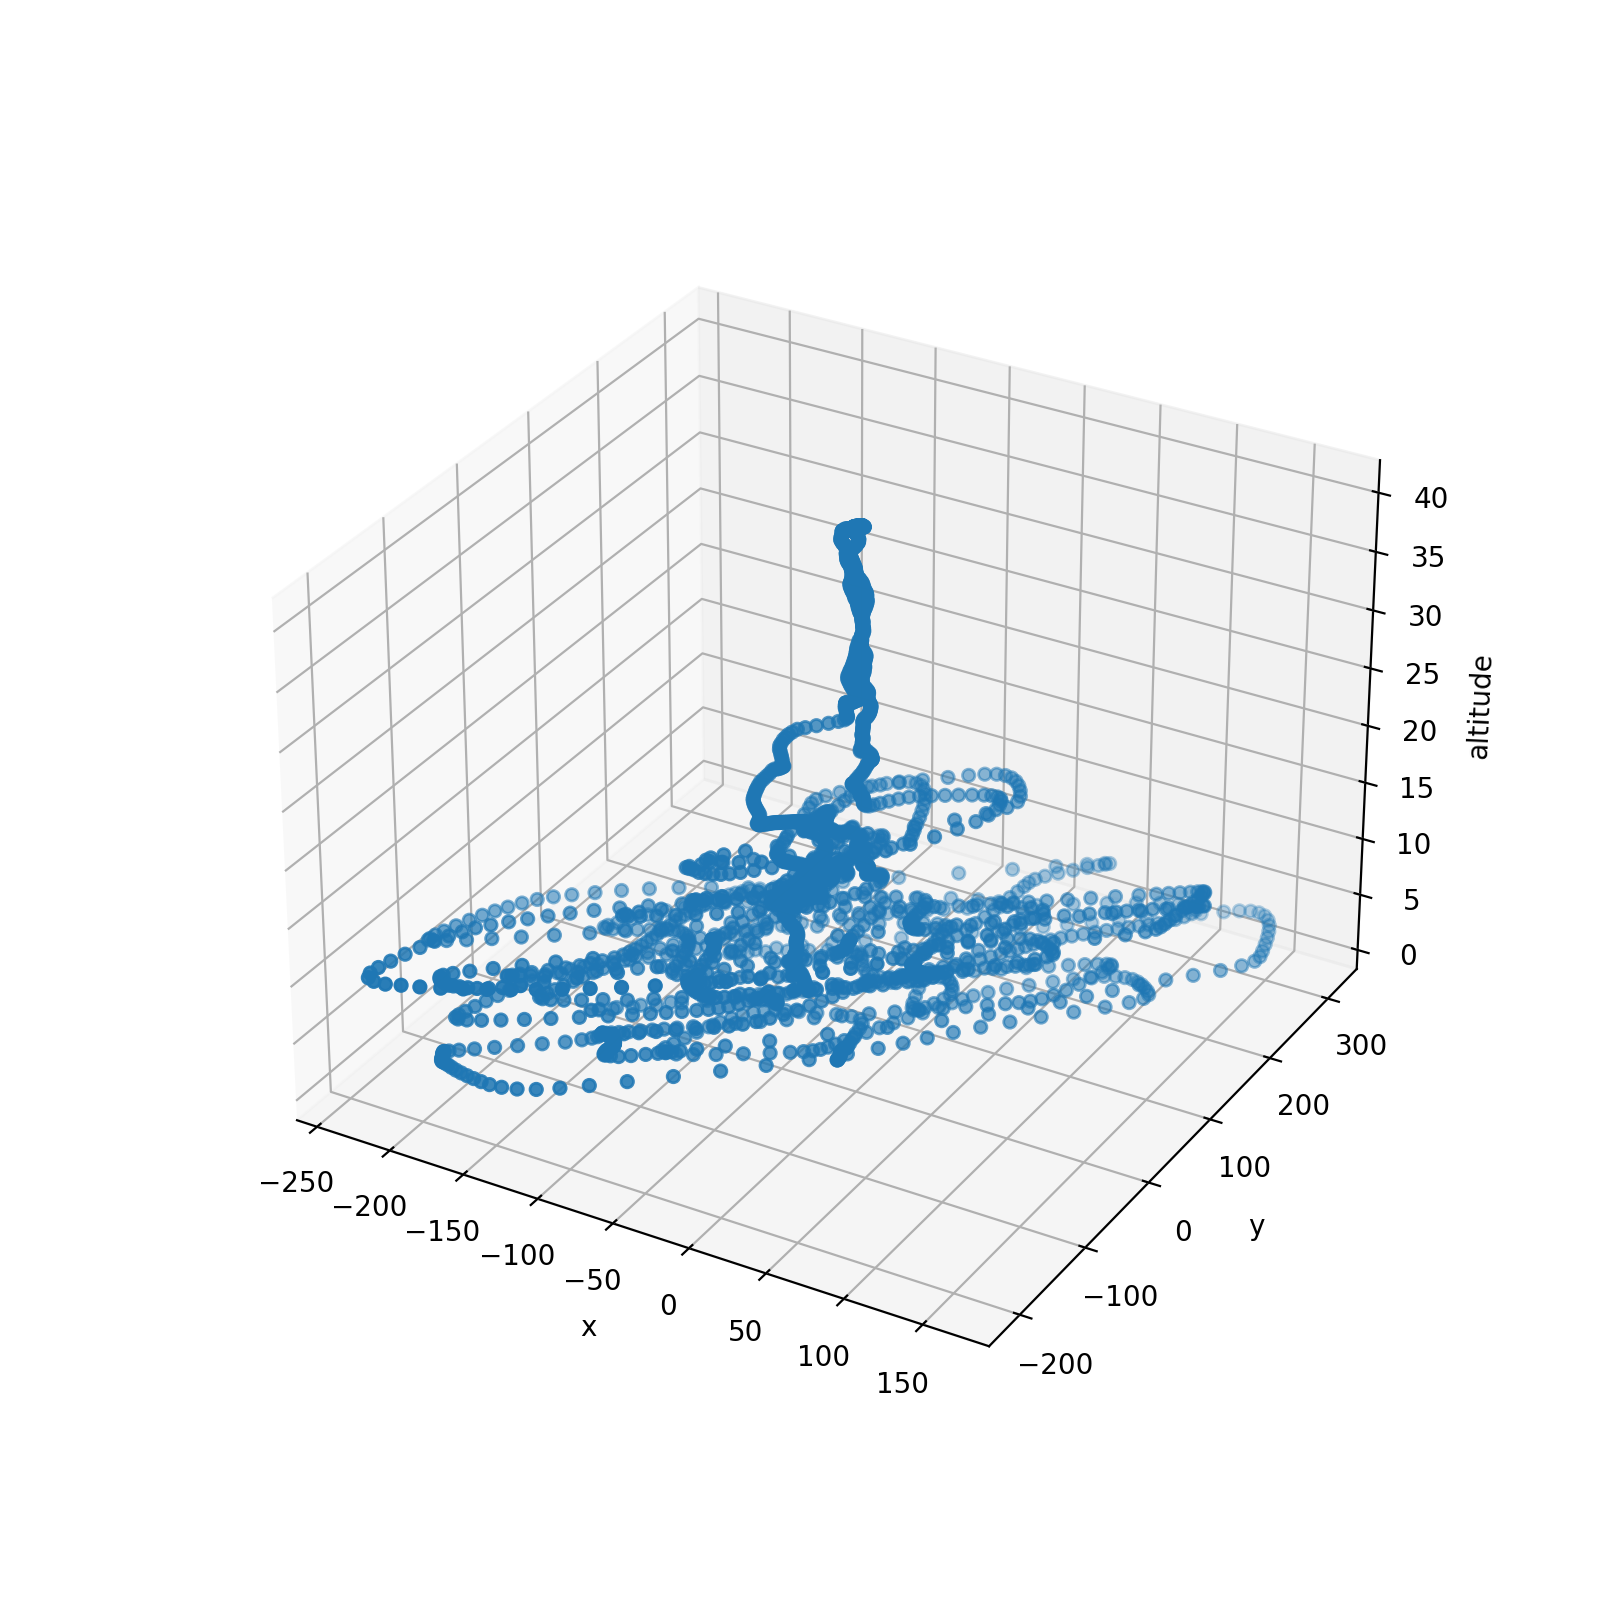

In [5]:
%matplotlib notebook

x = df["CART.x"]
y = df["CART.y"]
z = df["OSD.height[m]"]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('altitude')
ax.scatter(x, y, z)
plt.show()

In [6]:
starting_time = df["OSD.flyTime[s]"][0]

df["OSD.videoFlyTime[s]"] = df["OSD.flyTime[s]"] - starting_time

print(df["OSD.videoFlyTime[s]"][25:50])

25    5.0
26    5.2
27    5.4
28    5.6
29    5.8
30    6.0
31    6.2
32    6.4
33    6.6
34    6.8
35    7.0
36    7.2
37    7.4
38    7.6
39    7.8
40    8.0
41    8.2
42    8.4
43    8.6
44    8.8
45    9.0
46    9.2
47    9.4
48    9.6
49    9.8
Name: OSD.videoFlyTime[s], dtype: float64


In [8]:
vidcap = cv2.VideoCapture(str(videos_dir / 'flight.mp4'))
fps = vidcap.get(cv2.CAP_PROP_FPS)
print(fps)
success,image = vidcap.read()
count = 0
success = True

saved_frames = 1

df["savePath"] = ""

while success:
    success,frame = vidcap.read()
    count+=1
    
    t = round(count/fps, 2)

    if t-0.03 < df["OSD.videoFlyTime[s]"][saved_frames] and t+0.03 > df["OSD.videoFlyTime[s]"][saved_frames]:
        print(saved_frames, " Capture frame at time ", round(count/fps, 2), " drone time ", round(df["OSD.videoFlyTime[s]"][saved_frames], 2))
        
        frame_idx =  str(saved_frames).zfill(5)
        
        frame_filename = f"altitude={str(round(df['OSD.height[m]'][saved_frames], 2))}_{frame_idx}.jpg"
        
        df["savePath"][saved_frames] = str(frames_dir / frame_filename)
        
        cv2.imwrite(str(frames_dir / frame_filename), frame)
        saved_frames += 1

29.97002997002997
1  Capture frame at time  0.17  drone time  0.2
2  Capture frame at time  0.37  drone time  0.4


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3  Capture frame at time  0.57  drone time  0.6
4  Capture frame at time  0.77  drone time  0.8
5  Capture frame at time  1.0  drone time  1.0
6  Capture frame at time  1.17  drone time  1.2
7  Capture frame at time  1.37  drone time  1.4
8  Capture frame at time  1.57  drone time  1.6
9  Capture frame at time  1.77  drone time  1.8
10  Capture frame at time  2.0  drone time  2.0
11  Capture frame at time  2.17  drone time  2.2
12  Capture frame at time  2.37  drone time  2.4
13  Capture frame at time  2.6  drone time  2.6
14  Capture frame at time  2.8  drone time  2.8
15  Capture frame at time  3.0  drone time  3.0
16  Capture frame at time  3.17  drone time  3.2
17  Capture frame at time  3.37  drone time  3.4
18  Capture frame at time  3.57  drone time  3.6
19  Capture frame at time  3.8  drone time  3.8
20  Capture frame at time  4.0  drone time  4.0
21  Capture frame at time  4.17  drone time  4.2
22  Capture frame at time  4.37  drone time  4.4
23  Capture frame at time  4.57  d

165  Capture frame at time  33.0  drone time  33.0
166  Capture frame at time  33.2  drone time  33.2
167  Capture frame at time  33.4  drone time  33.4
168  Capture frame at time  33.57  drone time  33.6
169  Capture frame at time  33.77  drone time  33.8
170  Capture frame at time  34.0  drone time  34.0
171  Capture frame at time  34.2  drone time  34.2
172  Capture frame at time  34.4  drone time  34.4
173  Capture frame at time  34.57  drone time  34.6
174  Capture frame at time  34.77  drone time  34.8
175  Capture frame at time  35.0  drone time  35.0
176  Capture frame at time  35.2  drone time  35.2
177  Capture frame at time  35.4  drone time  35.4
178  Capture frame at time  35.57  drone time  35.6
179  Capture frame at time  35.77  drone time  35.8
180  Capture frame at time  36.0  drone time  36.0
181  Capture frame at time  36.2  drone time  36.2
182  Capture frame at time  36.4  drone time  36.4
183  Capture frame at time  36.57  drone time  36.6
184  Capture frame at ti

325  Capture frame at time  65.0  drone time  65.0
326  Capture frame at time  65.2  drone time  65.2
327  Capture frame at time  65.4  drone time  65.4
328  Capture frame at time  65.6  drone time  65.6
329  Capture frame at time  65.8  drone time  65.8
330  Capture frame at time  66.0  drone time  66.0
331  Capture frame at time  66.2  drone time  66.2
332  Capture frame at time  66.4  drone time  66.4
333  Capture frame at time  66.6  drone time  66.6
334  Capture frame at time  66.8  drone time  66.8
335  Capture frame at time  67.0  drone time  67.0
336  Capture frame at time  67.2  drone time  67.2
337  Capture frame at time  67.4  drone time  67.4
338  Capture frame at time  67.6  drone time  67.6
339  Capture frame at time  67.8  drone time  67.8
340  Capture frame at time  68.0  drone time  68.0
341  Capture frame at time  68.2  drone time  68.2
342  Capture frame at time  68.4  drone time  68.4
343  Capture frame at time  68.6  drone time  68.6
344  Capture frame at time  68.

485  Capture frame at time  97.0  drone time  97.0
486  Capture frame at time  97.2  drone time  97.2
487  Capture frame at time  97.4  drone time  97.4
488  Capture frame at time  97.6  drone time  97.6
489  Capture frame at time  97.8  drone time  97.8
490  Capture frame at time  98.0  drone time  98.0
491  Capture frame at time  98.2  drone time  98.2
492  Capture frame at time  98.4  drone time  98.4
493  Capture frame at time  98.6  drone time  98.6
494  Capture frame at time  98.8  drone time  98.8
495  Capture frame at time  99.0  drone time  99.0
496  Capture frame at time  99.2  drone time  99.2
497  Capture frame at time  99.4  drone time  99.4
498  Capture frame at time  99.6  drone time  99.6
499  Capture frame at time  99.8  drone time  99.8
500  Capture frame at time  100.0  drone time  100.0
501  Capture frame at time  100.2  drone time  100.2
502  Capture frame at time  100.4  drone time  100.4
503  Capture frame at time  100.6  drone time  100.6
504  Capture frame at t

639  Capture frame at time  127.79  drone time  127.8
640  Capture frame at time  127.99  drone time  128.0
641  Capture frame at time  128.19  drone time  128.2
642  Capture frame at time  128.39  drone time  128.4
643  Capture frame at time  128.6  drone time  128.6
644  Capture frame at time  128.8  drone time  128.8
645  Capture frame at time  129.0  drone time  129.0
646  Capture frame at time  129.2  drone time  129.2
647  Capture frame at time  129.4  drone time  129.4
648  Capture frame at time  129.6  drone time  129.6
649  Capture frame at time  129.8  drone time  129.8
650  Capture frame at time  130.0  drone time  130.0
651  Capture frame at time  130.2  drone time  130.2
652  Capture frame at time  130.4  drone time  130.4
653  Capture frame at time  130.6  drone time  130.6
654  Capture frame at time  130.8  drone time  130.8
655  Capture frame at time  131.0  drone time  131.0
656  Capture frame at time  131.2  drone time  131.2
657  Capture frame at time  131.4  drone t

793  Capture frame at time  158.59  drone time  158.6
794  Capture frame at time  158.79  drone time  158.8
795  Capture frame at time  158.99  drone time  159.0
796  Capture frame at time  159.19  drone time  159.2
797  Capture frame at time  159.39  drone time  159.4
798  Capture frame at time  159.59  drone time  159.6
799  Capture frame at time  159.79  drone time  159.8
800  Capture frame at time  159.99  drone time  160.0
801  Capture frame at time  160.19  drone time  160.2
802  Capture frame at time  160.39  drone time  160.4
803  Capture frame at time  160.59  drone time  160.6
804  Capture frame at time  160.79  drone time  160.8
805  Capture frame at time  160.99  drone time  161.0
806  Capture frame at time  161.19  drone time  161.2
807  Capture frame at time  161.39  drone time  161.4
808  Capture frame at time  161.59  drone time  161.6
809  Capture frame at time  161.79  drone time  161.8
810  Capture frame at time  162.0  drone time  162.0
811  Capture frame at time  1

947  Capture frame at time  189.39  drone time  189.4
948  Capture frame at time  189.59  drone time  189.6
949  Capture frame at time  189.79  drone time  189.8
950  Capture frame at time  189.99  drone time  190.0
951  Capture frame at time  190.19  drone time  190.2
952  Capture frame at time  190.39  drone time  190.4
953  Capture frame at time  190.59  drone time  190.6
954  Capture frame at time  190.79  drone time  190.8
955  Capture frame at time  190.99  drone time  191.0
956  Capture frame at time  191.19  drone time  191.2
957  Capture frame at time  191.39  drone time  191.4
958  Capture frame at time  191.59  drone time  191.6
959  Capture frame at time  191.79  drone time  191.8
960  Capture frame at time  191.99  drone time  192.0
961  Capture frame at time  192.19  drone time  192.2
962  Capture frame at time  192.39  drone time  192.4
963  Capture frame at time  192.59  drone time  192.6
964  Capture frame at time  192.79  drone time  192.8
965  Capture frame at time  

1099  Capture frame at time  219.79  drone time  219.8
1100  Capture frame at time  219.99  drone time  220.0
1101  Capture frame at time  220.19  drone time  220.2
1102  Capture frame at time  220.39  drone time  220.4
1103  Capture frame at time  220.59  drone time  220.6
1104  Capture frame at time  220.79  drone time  220.8
1105  Capture frame at time  220.99  drone time  221.0
1106  Capture frame at time  221.19  drone time  221.2
1107  Capture frame at time  221.39  drone time  221.4
1108  Capture frame at time  221.59  drone time  221.6
1109  Capture frame at time  221.79  drone time  221.8
1110  Capture frame at time  221.99  drone time  222.0
1111  Capture frame at time  222.19  drone time  222.2
1112  Capture frame at time  222.39  drone time  222.4
1113  Capture frame at time  222.59  drone time  222.6
1114  Capture frame at time  222.79  drone time  222.8
1115  Capture frame at time  222.99  drone time  223.0
1116  Capture frame at time  223.19  drone time  223.2
1117  Capt

1249  Capture frame at time  249.78  drone time  249.8
1250  Capture frame at time  249.98  drone time  250.0
1251  Capture frame at time  250.18  drone time  250.2
1252  Capture frame at time  250.38  drone time  250.4
1253  Capture frame at time  250.58  drone time  250.6
1254  Capture frame at time  250.78  drone time  250.8
1255  Capture frame at time  250.98  drone time  251.0
1256  Capture frame at time  251.18  drone time  251.2
1257  Capture frame at time  251.38  drone time  251.4
1258  Capture frame at time  251.58  drone time  251.6
1259  Capture frame at time  251.78  drone time  251.8
1260  Capture frame at time  251.99  drone time  252.0
1261  Capture frame at time  252.19  drone time  252.2
1262  Capture frame at time  252.39  drone time  252.4
1263  Capture frame at time  252.59  drone time  252.6
1264  Capture frame at time  252.79  drone time  252.8
1265  Capture frame at time  252.99  drone time  253.0
1266  Capture frame at time  253.19  drone time  253.2
1267  Capt

1399  Capture frame at time  279.78  drone time  279.8
1400  Capture frame at time  279.98  drone time  280.0
1401  Capture frame at time  280.18  drone time  280.2
1402  Capture frame at time  280.38  drone time  280.4
1403  Capture frame at time  280.58  drone time  280.6
1404  Capture frame at time  280.78  drone time  280.8
1405  Capture frame at time  280.98  drone time  281.0
1406  Capture frame at time  281.18  drone time  281.2
1407  Capture frame at time  281.38  drone time  281.4
1408  Capture frame at time  281.58  drone time  281.6
1409  Capture frame at time  281.78  drone time  281.8
1410  Capture frame at time  281.98  drone time  282.0
1411  Capture frame at time  282.18  drone time  282.2
1412  Capture frame at time  282.38  drone time  282.4
1413  Capture frame at time  282.58  drone time  282.6
1414  Capture frame at time  282.78  drone time  282.8
1415  Capture frame at time  282.98  drone time  283.0
1416  Capture frame at time  283.18  drone time  283.2
1417  Capt

1549  Capture frame at time  309.78  drone time  309.8
1550  Capture frame at time  309.98  drone time  310.0
1551  Capture frame at time  310.18  drone time  310.2
1552  Capture frame at time  310.38  drone time  310.4
1553  Capture frame at time  310.58  drone time  310.6
1554  Capture frame at time  310.78  drone time  310.8
1555  Capture frame at time  310.98  drone time  311.0
1556  Capture frame at time  311.18  drone time  311.2
1557  Capture frame at time  311.38  drone time  311.4
1558  Capture frame at time  311.58  drone time  311.6
1559  Capture frame at time  311.78  drone time  311.8
1560  Capture frame at time  311.98  drone time  312.0
1561  Capture frame at time  312.18  drone time  312.2
1562  Capture frame at time  312.38  drone time  312.4
1563  Capture frame at time  312.58  drone time  312.6
1564  Capture frame at time  312.78  drone time  312.8
1565  Capture frame at time  312.98  drone time  313.0
1566  Capture frame at time  313.18  drone time  313.2
1567  Capt

In [9]:
from pathlib import Path  
filepath = flightrecord_dir / 'out.csv'  
#filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath)